## Importing library and loading processed data

In [52]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.model_selection import GridSearchCV

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel



import spacy
nlp = spacy.load('en_core_web_sm')
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [53]:
from matplotlib import pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter
import plotly.tools as tls
import plotly.graph_objs as go
import base64
import numpy as np
import pandas as pd

import plotly.offline as py
py.init_notebook_mode(connected=True)

%matplotlib inline


In [54]:
df = pd.read_csv(
    'D:/Projects/Topic modelling/Code/topic_modelling/data_cleaning/processed_data_new.csv')


In [55]:
df.head()

,date,id,content,user,reply_count,retweet_count,likecount,quotecount,ct
0,2021-10-17 04:41:51+00:00,1.449600e+18,@SujibDr Thank Sir for the information. Last d...,https://twitter.com/MrinChemKar,0,0,0,0,thank information predict disastrous
1,2021-10-17 03:17:40+00:00,1.449580e+18,@biswajitmohanty when v hav allowed well entre...,https://twitter.com/amphan_may2020,0,0,0,0,century matter catch drug peddling
2,2021-10-16 15:06:12+00:00,1.449390e+18,"From the cities to the villages, Amphan left B...",https://twitter.com/ishadrita,1,0,1,0,left climate crisis
3,2021-10-16 15:03:42+00:00,1.449390e+18,"What many have mocked as my claim to stardom, ...",https://twitter.com/ishadrita,0,0,5,0,claim stardom believe night life floor apartment
4,2021-10-16 08:31:43+00:00,1.449290e+18,#WorldFoodDay2021 \nIn the cyclone Amphan deva...,https://twitter.com/ri_montu,0,7,17,0,area coast hard time live price rice broken ri...


In [56]:
df.isna().sum()

date             0
id               0
content          0
user             0
reply_count      0
retweet_count    0
likecount        0
quotecount       0
ct               1
dtype: int64

In [57]:
df=df.dropna()

In [58]:
df.shape

(51591, 9)

## Removing stopwords


In [59]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords])


In [60]:
df['ct'] = df['ct'].apply(lambda x: remove_stopwords(x))

In [61]:
df['ct']

0                     thank information predict disastrous
1                       century matter catch drug peddling
2                                      left climate crisis
3         claim stardom believe night life floor apartment
4        area coast hard time live price rice broken ri...
                               ...                        
51587                             understand pruce musical
51588                         fantastic sort gross theater
51589                                 pick pair glass cool
51590                               orchestra listen music
51591                        homework listen music instead
Name: ct, Length: 51591, dtype: object

In [62]:
text=df.ct.values.tolist()

## Modelling

In [63]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        print("="*70)


In [64]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemm = WordNetLemmatizer()

class LemmaCountVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))


In [65]:
tf_vectorizer = LemmaCountVectorizer(max_df=0.95,
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)


## LDA

In [66]:
lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=10)


In [67]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=10)

In [ ]:
# params = {
#     'n_components': [10, 12,15],
#     'learning_decay': [0.75, 0.80, 0.85]
# }

# lda_search = GridSearchCV(lda,
#                           param_grid=params,
#                           cv=3,
#                           return_train_score=False)

# lda_search.fit(tf)

# results = pd.DataFrame(lda_search.cv_results_)


In [ ]:
# best_lda_model = lda_search.best_estimator_
# print("Best Model's Params: ", lda_search.best_params_)


Best Model's Params:  {'learning_decay': 0.85, 'n_components': 10}


In [68]:
lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                learning_decay=0.85,
                                random_state=10)


In [69]:
lda.fit(tf)

LatentDirichletAllocation(learning_decay=0.85, learning_method='online',
                          learning_offset=50.0, max_iter=5, random_state=10)

## Getting our topics from the data using LDA

In [70]:
n_top_words = 40
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names_out()
print_top_words(lda, tf_feature_names, n_top_words)



Topics in LDA model: 

Topic #0:severe coast heavy wind coastal extremely rain speed impact alert intense high million devastate weather damage destruction strong pandemic east pray near world cross turn face rainfall leave late surge update locust crisis forecast brace hope bad attack save afternoon

Topic #1:medium coverage day power electricity survey cover service connection aerial damage scary leaf channel satellite post worry devastate republic normal team challenge supply situation visit city data rehabilitation speed social hour bad area talk tweet water base impact kind work

Topic #2:nature track deep mother twitter fast check right plus wrong beautiful true absolutely adjoin depression correct heat havoc wave fury hear list lose sorry think hard different fact shall destructive literally garden man great wel black middle heart pronounce understand

Topic #3:safety risk believe pray express bless wonderful sense nice suspend special look active resolve slow probably connect 

In [71]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[4]
fourth_topic = lda.components_[5]


In [72]:
first_topic.shape


(8564,)

In [73]:
first_topic_words = [tf_feature_names[i]
                     for i in first_topic.argsort()[:-50 - 1:-1]]
second_topic_words = [tf_feature_names[i]
                      for i in second_topic.argsort()[:-50 - 1:-1]]
third_topic_words = [tf_feature_names[i]
                     for i in third_topic.argsort()[:-50 - 1:-1]]
fourth_topic_words = [tf_feature_names[i]
                      for i in fourth_topic.argsort()[:-50 - 1:-1]]


## Visualising our wordcloud for topics

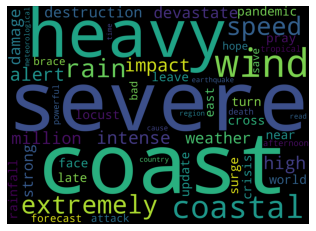

In [74]:
from wordcloud import WordCloud
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

firstcloud = WordCloud(
    stopwords=STOPWORDS,
    background_color='black',
    width=2500,
    height=1800
).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()


The above wordcloud says that the people were discussing about the cyclone its wind speed and when it will strike the coast of India

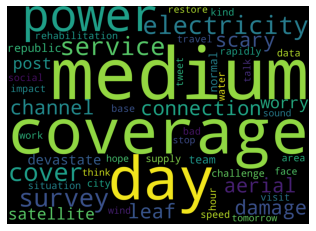

In [75]:
secondcloud = WordCloud(
    stopwords=STOPWORDS,
    background_color='black',
    width=2500,
    height=1800
).generate(" ".join(second_topic_words))
plt.imshow(secondcloud)
plt.axis('off')
plt.show()


The above wordcloud represents the service/electricity cut occured during the events

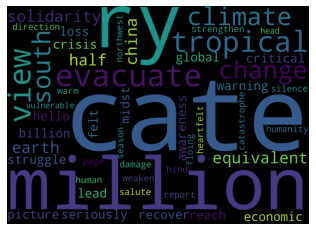

In [76]:
thirdcloud = WordCloud(
    stopwords=STOPWORDS,
    background_color='black',
    width=2500,
    height=1800
).generate(" ".join(third_topic_words))
plt.imshow(thirdcloud)
plt.axis('off')
plt.show()


The above wordcloud says that people were being moved to safety and evacuated from the impact zone

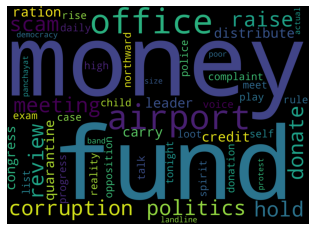

In [77]:
fourthcloud = WordCloud(
    stopwords=STOPWORDS,
    background_color='black',
    width=2500,
    height=1800
).generate(" ".join(fourth_topic_words))
plt.imshow(fourthcloud)
plt.axis('off')
plt.show()


The above wordcloud says that people were asking for help in any form to contribute for the flood/cyclone affected people and they were also talking about the poltics and lack of funds during the events

## Predict topics for given sentence

In [78]:
df_topic_keywords = pd.DataFrame(lda.components_)


In [79]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in [
                         '-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out


def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=[
                             'NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = tf_vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = lda.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(
        topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores





In [80]:
mytext = ["Feared from cyclone"]
topic, prob_scores = predict_topic(text=mytext)
print(topic)


[0.10022418901080116, 0.10011073320171204, 0.10010947309452288, 0.10009917544741052, 0.10011572543273897, 0.10032188855020302, 0.10011153943467457, 2.089249062261563, 0.10013659960843319, 0.10017339465564161, 0.10008974056877748, 0.10013592012829217, 0.10022181125182873, 0.10010282086778224, 0.10026722346261055, 0.10012051325642965, 0.10059427169219934, 0.10027392056999859, 0.10010098583267762, 1.2948800271951986, 0.10011106606941758, 0.10012306897803532, 0.10009105063499464, 1.5178232131296885, 0.10009243859839415, 0.10017866964419932, 0.10014244817547359, 0.10011880479356396, 57.91824439349822, 0.10014256828448792, 1.6377054183200161, 0.1001063070948574, 0.10012652880807167, 0.1009589336147447, 0.1000959813870992, 0.1012896838377507, 0.10011102364982348, 0.10010293340975904, 0.10011999462471531, 0.10015905669039285, 0.10013813480691353, 0.10013835446119876, 0.10036040637680878, 0.10019097608299121, 0.10010951736110087, 0.10011733609506741, 0.10015720602167341, 0.10010246662482167, 0.

In [81]:
lda_output = lda.transform(tf)


## Cluster documents that share same topic and similar topics

In [82]:
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

svd_model = TruncatedSVD(n_components=2)  
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 10 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(
    svd_model.explained_variance_ratio_, 2))


Component's weights: 
 [[ 0.51  0.24  0.17  0.14  0.16  0.17  0.71  0.16  0.12  0.18]
 [ 0.76  0.07  0.04  0.03  0.05  0.04 -0.63  0.04  0.02  0.05]]
Perc of Variance Explained: 
 [0.07 0.36]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

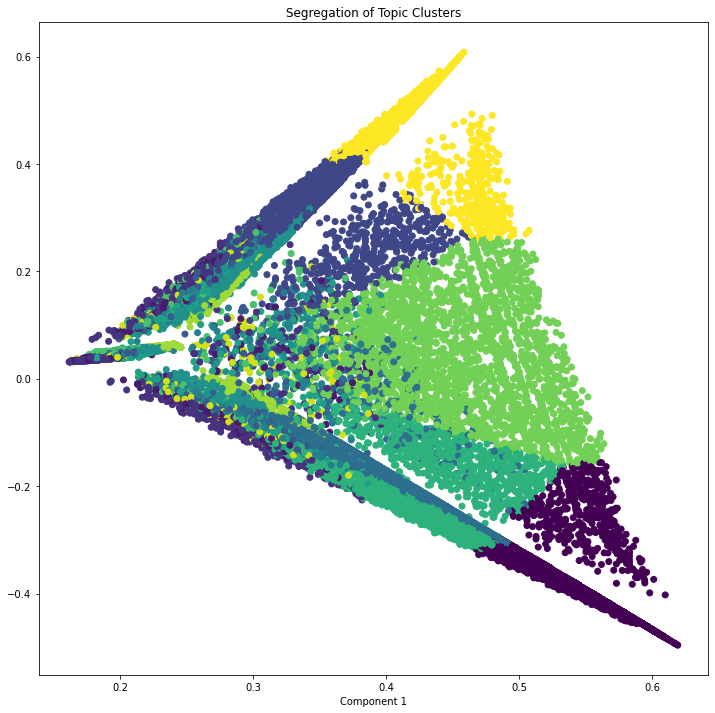

In [83]:
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )
